In [17]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
from snntorch import functional as SF
import brevitas.nn as qnn 

from tqdm import tqdm
import sys
sys.path.append('../src')
from RecurrentAHPC import RecurrentAhpc
from dataloader import WISDM_Dataset_parser, WISDM_Dataset
from torch.utils.data import  DataLoader

In [18]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using device {device}')

Using device cuda


In [19]:
batch_size = 512
# network parameters
num_inputs = 6 
num_steps = 40
num_hidden_1 = 128
num_hidden_2 = 256
num_hidden_3 = 128
num_outputs = 7
pop_outputs = num_outputs * 10
num_epochs = 200

# spiking neuron parameters
beta = 0.9  # neuron decay rate
grad = surrogate.fast_sigmoid()

In [20]:

dataset = WISDM_Dataset_parser('../data/watch_subset2_40.npz', norm=None)
train_set = dataset.get_training_set()
test_set = dataset.get_validation_set()

train_dataset = WISDM_Dataset(train_set)
test_dataset = WISDM_Dataset(test_set)

train_loader = DataLoader(dataset=train_dataset, batch_size=int(batch_size), shuffle=True, num_workers=8)
test_loader  = DataLoader(dataset= test_dataset, batch_size=int(batch_size), shuffle=True, num_workers=8)

(6,)
(6,)
num classes train dataset: 7 occurrences of each class:[3189 2987 3083 3262 3046 3071 3082]
num classes eval dataset: 7 occurrences of each class:[1050 1017  982  998 1058 1055 1080]
num classes test dataset: 7 occurrences of each class:[1031  948 1014 1076 1062 1038 1072]


In [21]:
import torch.nn.functional as F

class MyNetwork(nn.Module):
    def __init__(self, num_inputs, num_hidden_1, num_hidden_2, num_outputs, beta, grad):
        super(MyNetwork, self).__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden_1)
        self.leaky1 = snn.Leaky(beta=beta, spike_grad=grad, learn_beta=True, learn_threshold=True)
        self.linear2 = nn.Linear(num_hidden_1, num_hidden_2)
        self.recurrent = RecurrentAhpc(beta, beta, spike_grad=grad, back_grad=grad, linear_features=num_hidden_2, learn_beta=True, learn_threshold=True, learn_recurrent=True)
        self.linear3 = nn.Linear(num_hidden_2, num_outputs)
        self.leaky2 = snn.Leaky(beta=beta, spike_grad=grad, learn_beta=True, learn_threshold=True, output=True)

    def forward(self, data):
        spk_rec = []
        utils.reset(self)  # resets hidden states for all LIF neurons in net

        spk1, mem1 = self.recurrent.init_rleaky()
        for step in range(data.size(2)):
            x = self.linear1(data[:,:,step])
            x, _ = self.leaky1(x)
            x = self.linear2(x)
            spk1, mem1 = self.recurrent(x,spk1,mem1)
            x = self.linear3(x)
            x, _ = self.leaky2(x)
            spk_rec.append(x)
        return torch.stack(spk_rec)

# Create an instance of the network
net = MyNetwork(num_inputs, num_hidden_1, num_hidden_2, num_outputs, beta, grad).to(device)


In [22]:

def test_accuracy(data_loader, net, population_code=False, num_classes=False):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    tqdm_dataloader = tqdm(data_loader)
    for _, batch  in enumerate(tqdm_dataloader):
      data, targets = batch
      data = data.to(device)
      targets = targets.to(device)
      spk_rec = net(data)

      if population_code:
        acc += SF.accuracy_rate(spk_rec, targets, population_code=True, num_classes=num_outputs) * spk_rec.size(1)
      else:
        acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)

      total += spk_rec.size(1)
      tqdm_dataloader.set_description(f'\r[Test accuracy: {(acc/total)* 100:.2f}]')
  return acc/total

In [23]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=4690, 
    eta_min=0, 
    last_epoch=-1
)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2, num_classes=num_outputs, population_code=False)

In [24]:
train_acc_hist = []
train_loss_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(num_epochs):
    tqdm_dataloader = tqdm(train_loader)
    epoch_loss = []
    curr_spk = []
    curr_targets = []
    for i, batch in enumerate(tqdm_dataloader):
        data, targets = batch
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec =  net(data)
        loss_val = loss_fn(spk_rec, targets)
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        scheduler.step()
        if len(curr_spk) == 0:
            curr_spk = spk_rec.to('cpu').detach()
            curr_targets = targets.to('cpu').detach()
        else:

            curr_spk = torch.cat((curr_spk, spk_rec.to('cpu').detach()), dim=1)
            curr_targets = torch.cat((curr_targets, targets.to('cpu').detach()))

        # Store loss history for future plotting
        epoch_loss.append(loss_val.item())
        
        loss_mean = np.mean(epoch_loss)
        acc = SF.accuracy_rate(curr_spk, curr_targets)
        tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{num_epochs}] loss:{loss_mean:.2f} accuracy:{acc * 100:.2f}')
    
    train_loss_hist.append(loss_mean)    
    train_acc_hist.append(acc)

    test_acc = test_accuracy(test_loader, net, num_steps, num_classes=num_outputs)
    test_acc_hist.append(test_acc)
    


[Test accuracy: 38.28]:  80%|████████  | 12/15 [00:01<00:00, 11.72it/s]


KeyboardInterrupt: 

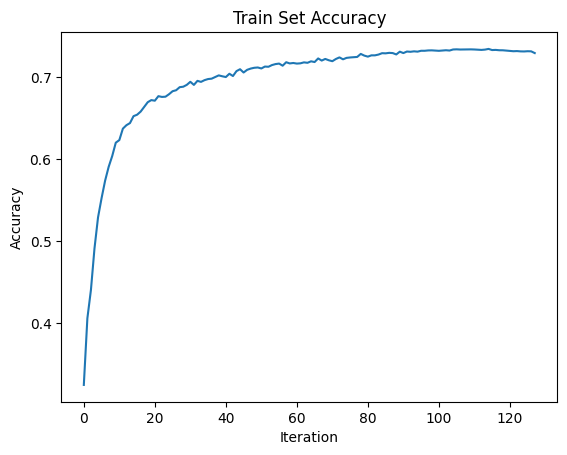

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor="w")
plt.plot(train_acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

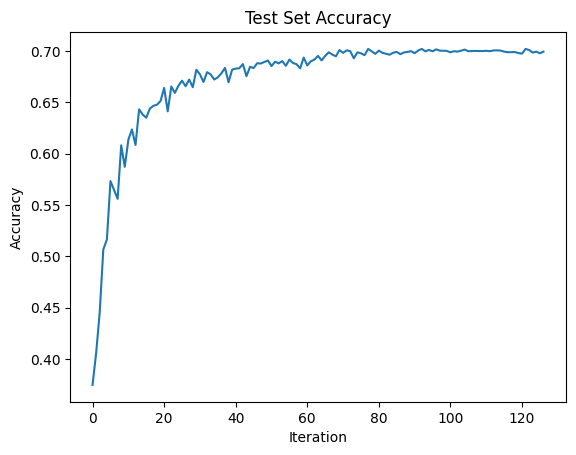

In [ ]:
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()